In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def manual_2d_fft(image):
    return np.fft.fft2(image)


def manual_2d_ifft(fft_image):
    return np.fft.ifft2(fft_image)


def create_gaussian_highpass_filter(shape, cutoff_freq):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2

    u_coords = np.arange(rows)
    v_coords = np.arange(cols)
    v_grid, u_grid = np.meshgrid(v_coords, u_coords)

    D = np.sqrt((u_grid - crow)**2 + (v_grid - ccol)**2)
    H_low = np.exp(-(D**2) / (2 * cutoff_freq**2))
    H_high = 1.0 - H_low

    return H_high, H_low


def create_emphasis_filter(shape, cutoff_freq, gamma_low, gamma_high):
    H_high, H_low = create_gaussian_highpass_filter(shape, cutoff_freq)
    H = (gamma_high - gamma_low) * H_high + gamma_low
    return H


def apply_frequency_filter_manual(image, H):
    F = manual_2d_fft(image)
    F_shifted = np.fft.fftshift(F)
    G_shifted = F_shifted * H
    G = np.fft.ifftshift(G_shifted)
    filtered = manual_2d_ifft(G)
    filtered = np.real(filtered)
    return filtered


def homomorphic_filter_grayscale(image, cutoff_freq=30, gamma_low=0.5, gamma_high=2.0):
    rows, cols = image.shape
    epsilon = 1e-10
    log_image = np.log(image + epsilon)

    H = create_emphasis_filter((rows, cols), cutoff_freq, gamma_low, gamma_high)
    filtered_log = apply_frequency_filter_manual(log_image, H)
    reflectance_estimate = np.exp(filtered_log)

    _, H_low = create_gaussian_highpass_filter((rows, cols), cutoff_freq)
    illumination_log = apply_frequency_filter_manual(log_image, H_low)
    illumination_estimate = np.exp(illumination_log)

    return reflectance_estimate, illumination_estimate, log_image, H


def normalize_image(img):
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-10)
    return img_norm


def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=np.float64)
    img_normalized = img_array / 255.0
    return img_normalized


def process_grayscale_image(image_path, cutoff_freq=40, gamma_low=0.3, gamma_high=2.0):
    image = load_and_preprocess_image(image_path)

    reflectance, illumination, log_img, filter_H = homomorphic_filter_grayscale(
        image, cutoff_freq, gamma_low, gamma_high
    )

    reflectance_norm = normalize_image(reflectance)
    illumination_norm = normalize_image(illumination)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Input Image I(x,y)', fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(log_img, cmap='gray')
    axes[0, 1].set_title('Log Domain: ln(I)', fontweight='bold')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(filter_H, cmap='hot')
    axes[0, 2].set_title('Emphasis Filter H(u,v)', fontweight='bold')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(reflectance_norm, cmap='gray')
    axes[1, 0].set_title('Recovered Reflectance R̂(x,y)', fontweight='bold')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(illumination_norm, cmap='hot')
    axes[1, 1].set_title('Estimated Illumination L̂(x,y)', fontweight='bold')
    axes[1, 1].axis('off')

    axes[1, 2].hist(image.flatten(), bins=50, alpha=0.5, label='Original', density=True)
    axes[1, 2].hist(reflectance_norm.flatten(), bins=50, alpha=0.5, label='Corrected', density=True)
    axes[1, 2].set_title('Histogram Comparison', fontweight='bold')
    axes[1, 2].set_xlabel('Intensity')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('grayscale_result.png', dpi=150, bbox_inches='tight')

    return reflectance_norm, illumination_norm


In [2]:
from google.colab import files
uploaded = files.upload()


Saving image (1).jpg to image (1).jpg


✓ Done!


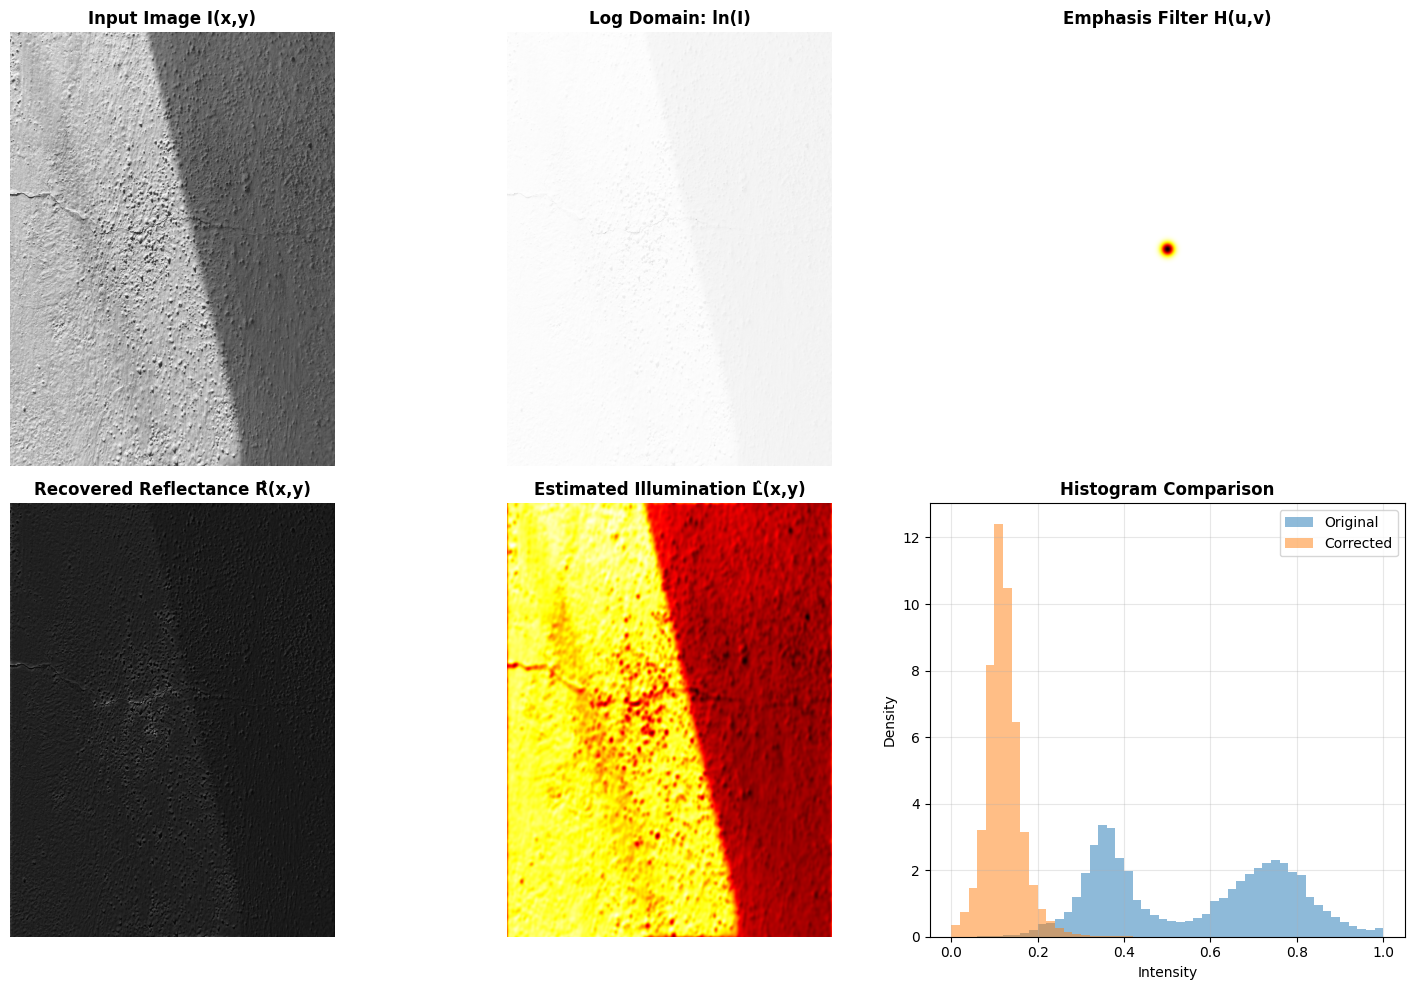

In [3]:
reflectance, illumination = process_grayscale_image('wall.jpg')

Image.fromarray((reflectance * 255).astype(np.uint8)).save('reflectance_output.jpg')
Image.fromarray((illumination * 255).astype(np.uint8)).save('illumination_output.jpg')

print("✓ Done!")


In [4]:
def homomorphic_filter_color_independent(image_rgb, cutoff_freq=30, gamma_low=0.5, gamma_high=2.0):
    channels_corrected = []

    for i in range(3):
        channel = image_rgb[:, :, i]
        reflectance, illumination, _, _ = homomorphic_filter_grayscale(
            channel, cutoff_freq, gamma_low, gamma_high
        )
        channels_corrected.append(normalize_image(reflectance))

    result = np.dstack(channels_corrected)
    return result


def homomorphic_filter_color_chromaticity_preserving(image_rgb, cutoff_freq=30, gamma_low=0.5, gamma_high=2.0):
    intensity = np.mean(image_rgb, axis=2)

    intensity_corrected, illumination, _, _ = homomorphic_filter_grayscale(
        intensity, cutoff_freq, gamma_low, gamma_high
    )
    intensity_corrected_norm = normalize_image(intensity_corrected)

    epsilon = 1e-10
    r_ratio = image_rgb[:, :, 0] / (intensity + epsilon)
    g_ratio = image_rgb[:, :, 1] / (intensity + epsilon)
    b_ratio = image_rgb[:, :, 2] / (intensity + epsilon)

    r_corrected = r_ratio * intensity_corrected_norm
    g_corrected = g_ratio * intensity_corrected_norm
    b_corrected = b_ratio * intensity_corrected_norm

    result = np.dstack([r_corrected, g_corrected, b_corrected])
    result = np.clip(result, 0, 1)

    return result, intensity_corrected_norm, illumination


def homomorphic_filter_color_joint_spectral(image_rgb, cutoff_freq=30, gamma_low=0.5, gamma_high=2.0):
    reflectances = []
    illuminations = []

    for i in range(3):
        channel = image_rgb[:, :, i]
        reflectance, illumination, _, _ = homomorphic_filter_grayscale(
            channel, cutoff_freq, gamma_low, gamma_high
        )
        reflectances.append(reflectance)
        illuminations.append(illumination)

    illumination_joint = np.power(
        illuminations[0] * illuminations[1] * illuminations[2],
        1/3
    )

    corrected_channels = []

    for i in range(3):
        reflectance_norm = normalize_image(reflectances[i])
        channel_mean_orig = np.mean(image_rgb[:, :, i])
        channel_mean_corrected = np.mean(reflectance_norm)
        correction_factor = channel_mean_orig / (channel_mean_corrected + 1e-10)
        corrected = reflectance_norm * (0.7 + 0.3 * correction_factor)
        corrected_channels.append(corrected)

    result = np.dstack(corrected_channels)
    result = np.clip(result, 0, 1)

    return result, illumination_joint


def load_color_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img, dtype=np.float64) / 255.0
    return img_array


def process_color_image(image_path, method='chromaticity', cutoff_freq=40, gamma_low=0.3, gamma_high=2.0):
    image = load_color_image(image_path)

    if method == 'independent':
        result = homomorphic_filter_color_independent(
            image, cutoff_freq, gamma_low, gamma_high
        )
        illumination = None
    elif method == 'chromaticity':
        result, intensity_corrected, illumination = homomorphic_filter_color_chromaticity_preserving(
            image, cutoff_freq, gamma_low, gamma_high
        )
    else:
        result, illumination = homomorphic_filter_color_joint_spectral(
            image, cutoff_freq, gamma_low, gamma_high
        )

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Color Image', fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(result)
    axes[0, 1].set_title(f'Corrected ({method})', fontweight='bold')
    axes[0, 1].axis('off')

    if illumination is not None:
        axes[0, 2].imshow(illumination, cmap='hot')
        axes[0, 2].set_title('Estimated Illumination', fontweight='bold')
        axes[0, 2].axis('off')

    colors = ['red', 'green', 'blue']
    for i, (color, ax) in enumerate(zip(colors, [axes[1, 0], axes[1, 1], axes[1, 2]])):
        ax.hist(image[:, :, i].flatten(), bins=50, alpha=0.5,
                color=color, label='Original', density=True)
        ax.hist(result[:, :, i].flatten(), bins=50, alpha=0.5,
                color=color, label='Corrected', density=True, linestyle='--')
        ax.set_title(f'{color.capitalize()} Channel', fontweight='bold')
        ax.set_xlabel('Intensity')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'color_result_{method}.png', dpi=150, bbox_inches='tight')

    return result


In [5]:
from google.colab import files
uploaded = files.upload()


Saving generated-image (1).png to generated-image (1).png


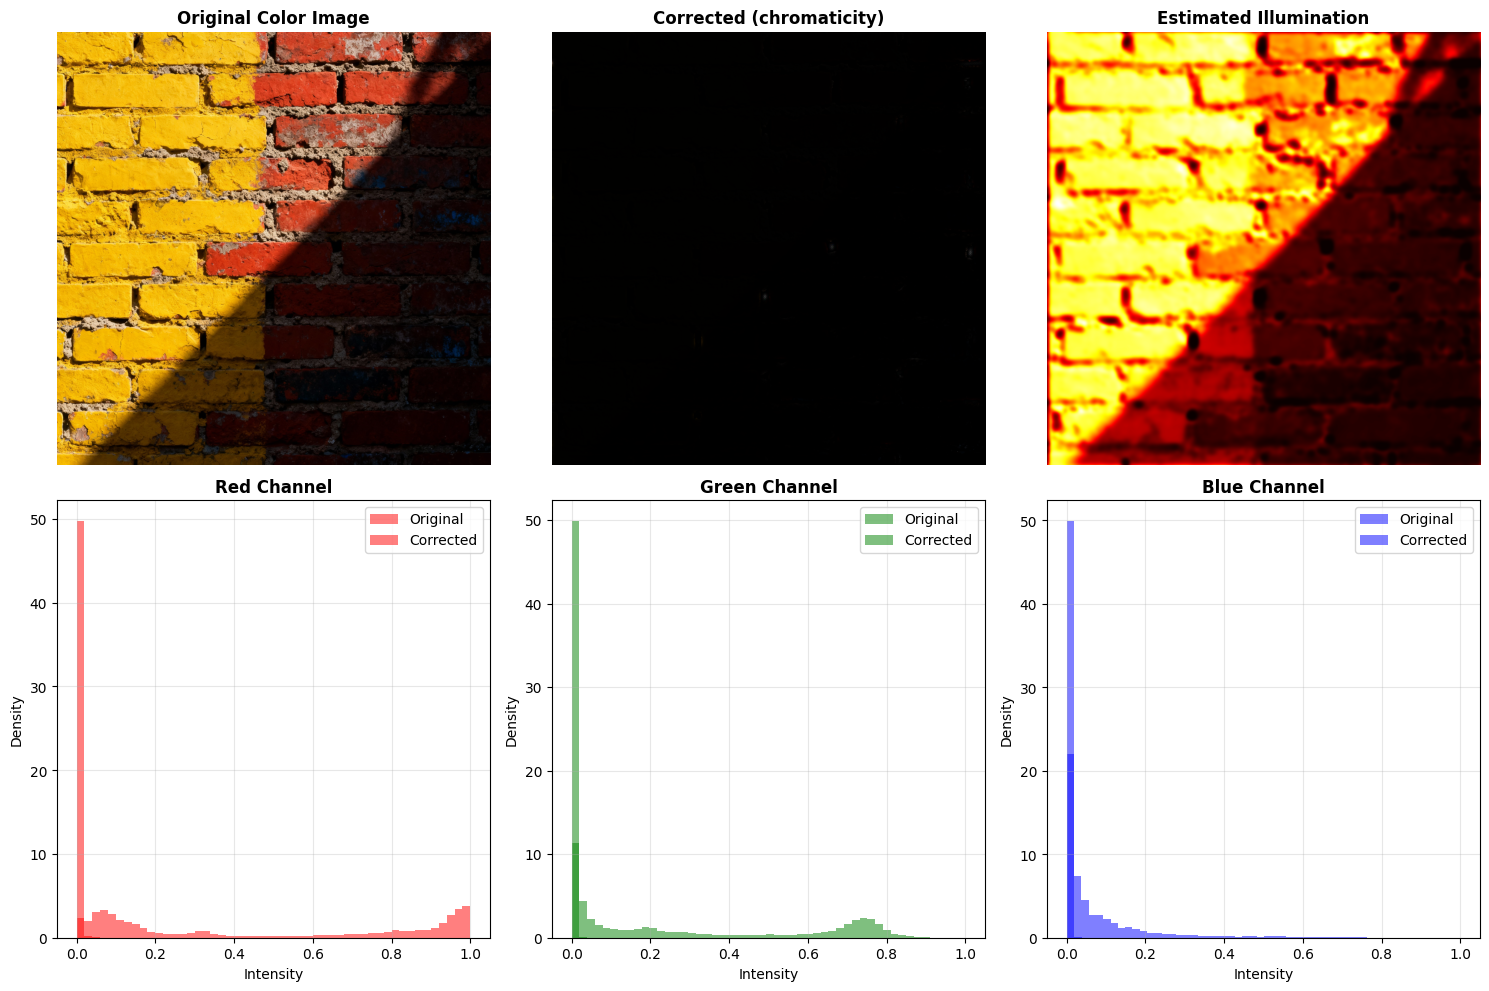

In [6]:
result = process_color_image('colourwall.png',
                            method='chromaticity',
                            cutoff_freq=30,
                            gamma_low=0.5,
                            gamma_high=1.5)


